In [1]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [2]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Opening data file

In [3]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

print (type(mat_contents))
mat_contents.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'dataset', 'labels'])

### Separating parameters and labels

In [4]:
print ('dataset: ',mat_contents['dataset'].shape)
print ('labels: ',mat_contents['labels'].shape)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases, experiments

y = mat_contents['labels'].reshape(Nc)
print ('y: ',len(y))
y[::50]

dataset:  (8192, 5, 850)
labels:  (1, 850)
y:  850


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

### Creating new label y2 considering the classification as: (in case we use it as a supervised label instead of the 17 classes)

y=(1..9) - undamaged, y2 = -1

y=(10..17) - damaged, y2 = 1

Text(0, 0.5, 'y2')

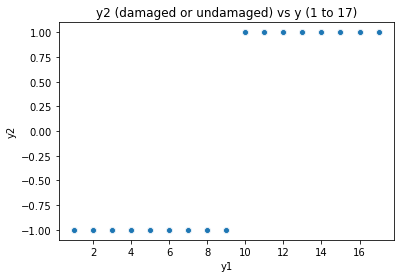

In [5]:
y2 = []
for label in y:
    if label in range(1,10):
        y2.append(-1)
    else: y2.append(1)
y2 = np.array(y2)
ax = sns.scatterplot(y,y2)
ax.set_title('y2 (damaged or undamaged) vs y (1 to 17)')
ax.set_xlabel('y1')
ax.set_ylabel('y2')

### Plotting Specific Channel Data

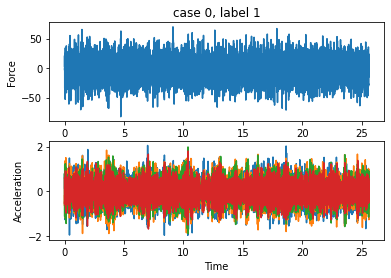

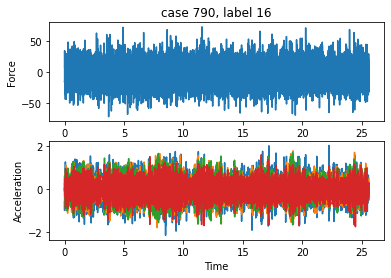

In [6]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.subplots()
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

### Transposing the channel dat: Ch(i) > X(i), i in {2,3,4,5}

In [7]:
x2 = Ch2.transpose()
x3 = Ch3.transpose()
x4 = Ch4.transpose()
x5 = Ch5.transpose()

### Fitting AR model and building X1 matrix

In [8]:
modelOrder = 30

x2r = []
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

Text(0, 0.5, 'Cumulative Explained Variance [%]')

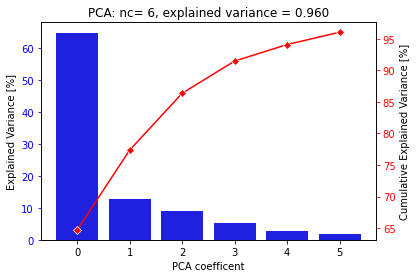

In [9]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b')
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D')
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')

### Building x2 by transforming the x1 data with the previous PCA model

In [10]:
X2 = pca.fit_transform(X1)
X2.shape

(850, 6)

### Scaling features form both X1 and X2

In [11]:
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

print ("not scaled: ", X2[0], "\nscaled: ", X2_scaled[0])

not scaled:  [ 7.66136505 -1.41780663  0.80665171  0.89625556 -1.19463583 -0.13840328] 
scaled:  [ 0.75017416 -0.61278049  0.16699462 -0.2637636  -0.44727164 -0.14540835]


### Creating pandas dataframe versions of the scaled x1, x1+label, x2 and x2+label

In [12]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1_label = dfx1.copy()
dfx1_label['label'] = y
dfx1_label['stateCondition'] = y2

dfx2 = pd.DataFrame(X2_scaled)
dfx2_label = dfx2.copy()
dfx2_label['label'] = y
dfx2_label['stateCondition'] = y2

dfx2_label.sample(10)

,0,1,2,3,4,5,label,stateCondition
612,-0.903436,-0.671451,0.214512,-0.562129,-0.127958,0.130858,13,1
754,-0.545147,-0.478641,-0.810216,-0.590791,0.189786,-0.069232,16,1
84,0.472311,-0.509489,0.035659,-0.689403,0.145242,-0.280637,2,-1
550,-0.864537,-0.637157,0.107870,-0.367822,0.047620,0.045850,12,1
552,-0.838279,-0.662375,-0.015673,-0.562323,-0.003970,0.027502,12,1
746,-0.118013,-0.442991,-0.657061,-0.719729,0.040563,0.086576,15,1
232,-0.139133,0.909010,0.124730,-0.267940,0.069659,0.873626,5,-1
697,-0.987715,-0.169648,1.000000,-0.330526,-0.427633,-0.282706,14,1
564,-0.855371,-0.522773,0.179346,-0.513061,-0.040935,-0.110881,12,1
313,-0.106299,-0.448998,-0.710600,-0.011706,-0.145539,0.051685,7,-1


### AR x PCA correlation heatmap

Text(0.5, 0.98, 'Correlation matrix between the parameters')

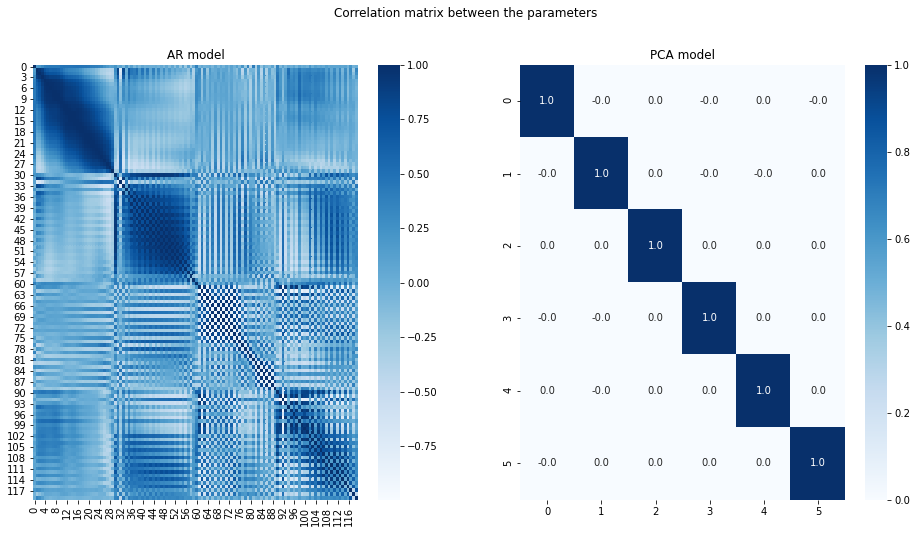

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(121)
ax = sns.heatmap(dfx1.corr(), cmap='Blues')
ax.set_title('AR model')

plt.subplot(122)
ax2 = sns.heatmap(dfx2.corr(), cmap='Blues' ,annot=True, fmt='.1f')
ax2.set_title('PCA model')

fig.suptitle('Correlation matrix between the parameters')


#### Note
No correlation left between the parameters after PCA transform, as after dimmensionallity reduction they're all independent

### Crossplot of the first three features of the PCA analysis using labels as the 17 classes or states

Text(0.5, 0.98, 'First 3-PCA Components Pairwise Plots')

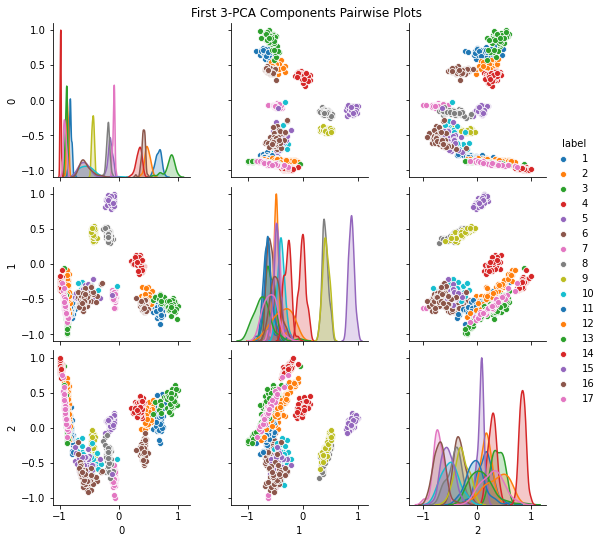

In [30]:
pp = sns.pairplot(data=dfx2_label.iloc[:,[0,1,2,-2]], hue='label', palette='tab10')
pp.fig.subplots_adjust(top=0.95, wspace=0.3)
pp.fig.suptitle('First 3-PCA Components Pairwise Plots')

### Crossplot of the first three features of the PCA analysis using the states undamaged (-1) and damaged (1)

Text(0.5, 0.98, 'First 3-PCA Components Pairwise Plots')

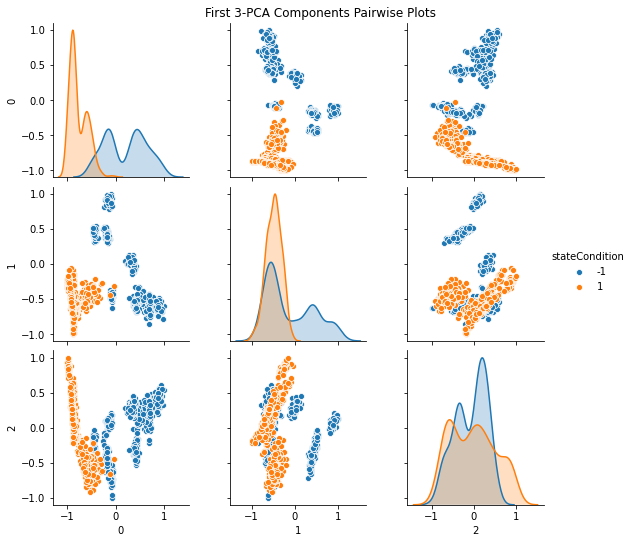

In [31]:
pp = sns.pairplot(data=dfx2_label.iloc[:,[0,1,2,-1]], hue='stateCondition', palette='tab10')
pp.fig.subplots_adjust(top=0.95, wspace=0.3)
pp.fig.suptitle('First 3-PCA Components Pairwise Plots')

### Plotting Multidimenssional Spaces

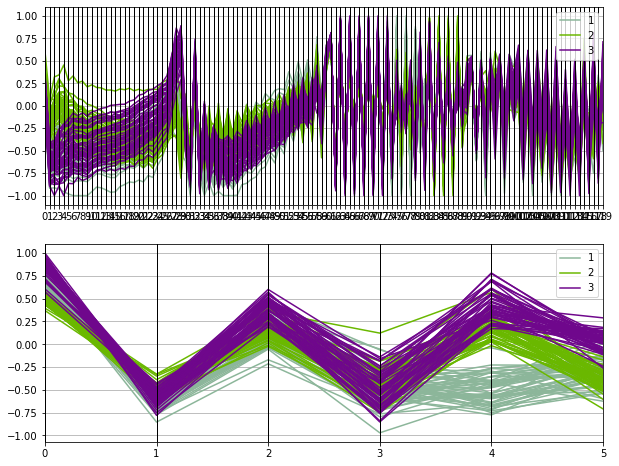

In [32]:
plt.figure(figsize=(10,8))
plt.subplot(211)
# pd.plotting.parallel_coordinates(dfx1_label, 'label')
pd.plotting.parallel_coordinates(dfx1_label[dfx1_label['label']<=3].iloc[:,:-1], 'label')        #iloc[:,[0,1,2,-1]]
plt.subplot(212)
# pd.plotting.parallel_coordinates(dfx2_label, 'label')
pd.plotting.parallel_coordinates(dfx2_label[dfx2_label['label']<=3].iloc[:,:-1], 'label')

#### Note:
Testing some values for the classes the comparison above suggests that it won't be easy to distinguish between classes 2 and 3 using the PCA features

### Plotting Multidimenssional Spaces (damaged or undamaged)

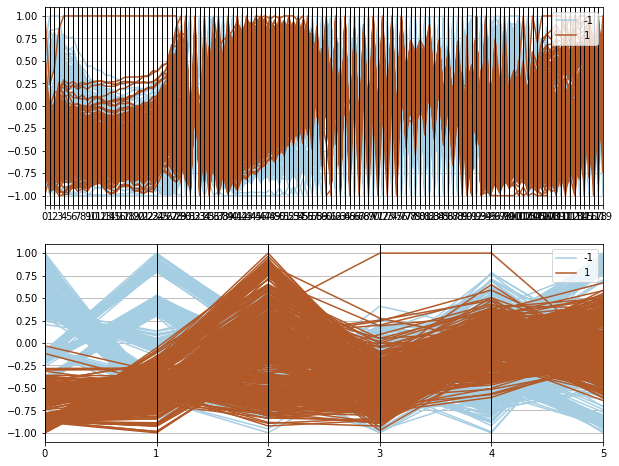

In [33]:
plt.figure(figsize=(10,8))
plt.subplot(211)
# pd.plotting.parallel_coordinates(dfx1_label, 'label')
pd.plotting.parallel_coordinates(dfx1_label.loc[:, dfx1_label.columns != 'label'], 'stateCondition', colormap=plt.get_cmap('Paired'))
plt.subplot(212)
# pd.plotting.parallel_coordinates(dfx2_label, 'label')
pd.plotting.parallel_coordinates(dfx2_label.loc[:, dfx2_label.columns != 'label'], 'stateCondition', colormap=plt.get_cmap('Paired'))

### Choosing labels to train the model

In [34]:
# Escolher se modelos serão treinados com o label y = {1..17} ou y2 = {-1,1}
yModelo = y
# yModelo = y2

### Preparing data by separating train and test 

In [35]:
# From now on we dont use the '_scaled' for the test and train ensemples anymore

test_size = 0.20
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, yModelo, test_size=test_size, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, yModelo, test_size=test_size, random_state=10)

print ('|Train X1|:', X1_train.shape[0])
print ('|Test X1|:', X1_test.shape[0])
print ('|Train y|:', len(y_train))
print ('|Test y|:', len(y_test))

# Check if the y split is the same in both calls of train_test_split
print ('This must be zero: ', sum(y2_train-y_train))
print ('This must also be zero: ', sum(y2_test-y_test))

# type(y2)

|Train X1|: 680
|Test X1|: 170
|Train y|: 680
|Test y|: 170
This must be zero:  0
This must also be zero:  0


### Softmax Linear Model (logistic regression with multiple classes)

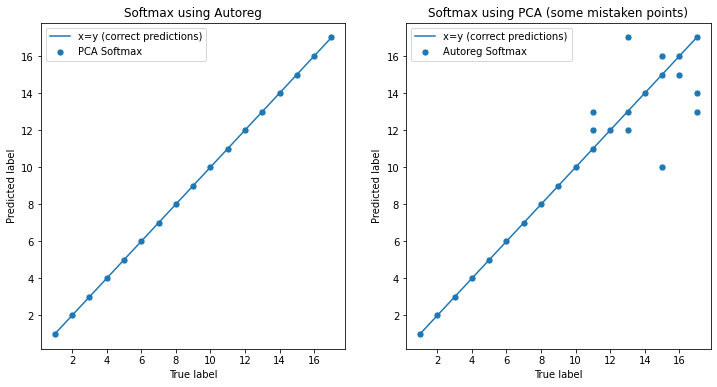

In [36]:
model1 = LogisticRegression(multi_class='multinomial', max_iter=200).fit(X1_train, y_train)
model2 = LogisticRegression(multi_class='multinomial', max_iter=200).fit(X2_train, y_train)

yPred1_train = model1.predict(X1_train)
yPred1_test = model1.predict(X1_test)

yPred2_train = model2.predict(X2_train)
yPred2_test = model2.predict(X2_test)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 6))
x=np.arange(1,18,1);

ax1 = sns.scatterplot(y_test,yPred1_test, s=50, ax=ax1, palette='colorblind');
ax1.set_xlabel('True label');
ax1.set_ylabel('Predicted label');
ax1=sns.lineplot(x=x, y=x, ax=ax1);
ax1.legend(['x=y (correct predictions)','PCA Softmax']);

ax2 = sns.scatterplot(y_test,yPred2_test, s=50, ax=ax2);
ax2.set_xlabel('True label');
ax2.set_ylabel('Predicted label');
ax2=sns.lineplot(x=x, y=x, ax=ax2);
ax2.legend(['x=y (correct predictions)','Autoreg Softmax']);

ax1.set_title('Softmax using Autoreg');
ax2.set_title('Softmax using PCA (some mistaken points)');


#### Note:
Although we have a good result in using PCA to reduce dimensionality to a few parameters, it seems like we lose a bit of information on the dataset. Indeed, the Auto Regression model performed better in classifying that dataset

### Measuring Accuracies

In [37]:
#storing results in a 2x2 matrix
dfResults = pd.DataFrame({
        'Model': ['Autoreg', 'PCA'], 
        'Train': [accuracy_score(y_train, yPred1_train), accuracy_score(y_train, yPred2_train)], 
        'Test': [accuracy_score(y_test, yPred1_test), accuracy_score(y_test, yPred2_test)]})
# unpivot dfResults in case of plotting graphs
dfResults = dfResults.melt(id_vars='Model', value_name='Accuracy', var_name='Ensemble')
dfResults


,Model,Ensemble,Accuracy
0,Autoreg,Train,0.998529
1,PCA,Train,0.900000
2,Autoreg,Test,1.000000
3,PCA,Test,0.882353
